In [67]:
import pandas as pd
import numpy as np
import csv
import scipy
import sys
import os
import matplotlib.pyplot as plt

%matplotlib inline

# ------------------------
# Периодические задачи
# ------------------------

## Характеристики задачи

In [3]:
def find_features_tasks(df):
    '''
    Находит следующие характеристики для задачи
    Число задач
    Общее время выполнения
    Общий период
    Число разделов
    Загрузка(отношение общего времени выполнения к общему периоду)
    Число интервалов
    '''
    Time = 1
    periods = df['period'].as_matrix()
    runtimes = df['runtime'].as_matrix()
    partitions = df['partition'].as_matrix()
    
    num_tasks = df.shape[0]
    num_part = len(np.unique(np.sort(partitions)))
    print("Num of partitions: ", num_part)
    for x in periods:
        Time = NOK(Time, x)
        
    counts = np.array([Time/x for x in periods])
    
    all_runtime = sum(runtimes[i]*counts[i] for i in range(len(df)))
    print("All_runtime: ",all_runtime)
    
    intervals = set()
    intervals.add(0)
    for x in periods:
        y = x
        while(y <= Time):
            intervals.add(y);
            y += x;
            
    num_of_intervals = len(intervals) - 1;
    print("All time: ",Time)
    load = all_runtime / Time
    print('Load: ', load)
    print("Число интервалов: ", num_of_intervals)
    return tuple((num_tasks,all_runtime, Time, num_part, load, num_of_intervals))
    
    

In [4]:
def NOD(a, b):
    while a != 0 and b != 0:
        if a > b:
            a %= b
        else:
            b %= a
    return a + b


def NOK(a, b):
    return a*b / NOD(a, b)


## Генерация по распределению  

Создается таблица разделы х задачи, в ячейках указывается время работы, как часть от периода.
И задается такая же табличка для периодов.
Можно указать загрузку.

num_tasks - вектор числа задач по разделам

mode - normal - равномерное распределени

In [39]:
def create_distrib(num_tasks, max_period = 10, mode='normal', mul_period=10, part=None, load=1.):
    if (mode == 'normal'):
        num_part = len(num_tasks)
        max_tasks = max(num_tasks)
        all_tasks = sum(num_tasks)
        distrib = np.zeros((num_part, max_tasks))
        period = np.zeros((num_part, max_tasks))
        for i in range(num_part):
            for j in range(num_tasks[i]):
                period[i][j] = int(np.random.randint(1, max_period + 1)) * mul_period
                distrib[i][j] = load*1./all_tasks
        return distrib, period
    elif (mode == 'one_part'):
        num_part = num_tasks.shape[0]
        max_tasks = num_tasks.max()
        all_tasks = num_tasks.sum() - 1
        distrib = np.zeros((num_part, max_tasks))
        period = np.zeros((num_part, max_tasks))
        for i in range(num_part):
            for j in range(num_tasks[i]):
                period[i][j] = int(np.random.randint(1, max_period + 1)) * mul_period
                distrib[i][j] = load*(1.-part)/all_tasks
        period[0][0] = max_period * mul_period
        distrib[0][0] = part * load
        return distrib, period

In [38]:
def create_tasks_by_distrib(task_distrib, periods):
    '''
    Create one task for static-dynamic shedule
    task_distrib - nparray
    first axis - partition, second axis - distribution of time for every
    periods - periods for tasks
    '''
    df = pd.DataFrame(columns=['partition', 'runtime', 'period'])
    for i in range(task_distrib.shape[0]):
        for j in range(task_distrib.shape[1]):
            if (task_distrib[i][j] == 0):
                break
                
            d = np.array([0, 0, 0], dtype=int)
            d[0] = i + 1
            d[2] = periods[i][j]
            d[1] = task_distrib[i][j] * d[2]
            if (d[1] <= 1.):
                d[1] = 1.
            df.loc[len(df)] = d
    return df
    

In [7]:
example_distrib = np.array([[0.1, 0.3, 0.2],
                            [0.1, 0, 0],
                            [0.2, 0 ,0]])
example_periods = np.array([[10, 20, 40],
                            [50, 0, 0],
                            [100, 0 ,0]])

In [37]:
def create_test_sample_dist(num_tasks, DIR, mul_period=10, mode='normal', part=None, max_period = 10, load=1., time_to_switch = 1):
    '''
    num_tasks - список массивов
    Создает len(num_tasks) файлов с именами testi.tsv, где i - номер задачи
    В файл meta.tsv помещается информация об этих задачах
    Возвращает строку с именами файлов, записанными через запятую
    '''

    os.mkdir(DIR)
    with open(DIR+'/TEST.txt', 'w') as file_output:
        df_f =  pd.DataFrame(columns=['num_tasks','all_runtime', 'Time', 'num_part', 'load', 'num_of_intervals', 'time_to_switch'])
        for x in range(num_tasks.shape[0]):
            file = DIR+"/test" + str(x) + ".tsv"
            file_output.write(file+' '+str(time_to_switch)+'\n');
            print (num_tasks[x])
            distr, period = create_distrib(num_tasks[x], mul_period=mul_period, mode=mode, part=part, max_period=max_period, load=load)
            df = create_tasks_by_distrib(distr, period)
            df.to_csv(file, sep ="\t")

            features = find_features_tasks(df)       
            node = np.empty((len(features))+1)
            for i in range(len(features)):
                node[i] = features[i]
            node[len(features)] = time_to_switch
            df_f.loc[len(df_f)] = node 
        
    df_f.to_csv(DIR+"/meta.tsv", sep="\t")

In [33]:
tasks = np.array([[6, 2, 3],
                  [1, 2, 4],
                  [1, 2]])

In [36]:
create_test_sample_dist(tasks, "TestXIIIIII", mul_period=1000, mode='normal', max_period=10, load=0.7)

[6, 2, 3]
Num of partitions:  3
All_runtime:  586597.0
All time:  840000.0
Load:  0.698329761905
Число интервалов:  840
[1, 2, 4]
Num of partitions:  3
All_runtime:  83901.0
All time:  120000.0
Load:  0.699175
Число интервалов:  64
[1, 2]
Num of partitions:  2
All_runtime:  8393.0
All time:  12000.0
Load:  0.699416666667
Число интервалов:  6


## Равномерное распределение параметров задач

In [16]:
def create_tasks_random(num_tasks, num_part, max_period):
    '''
    Create one task for static-dynamic shedule
    равномерное распределение
    
    '''
    df = pd.DataFrame(columns=['partition', 'runtime', 'period'])
    for i in range(num_tasks):
        d = np.array([0, 0, 0], dtype=int)
        d[0] = np.random.randint(1, num_part + 1)
        d[2] = np.random.randint(1, max_period + 1) * 10
        d[1] = np.random.randint(1, (1.8 * d[2] / num_tasks) + 1)
        df.loc[len(df)] = d
    return df
    

In [48]:
def create_test_sample(n_problems, part_c, max_period, tasks_c, time_to_switch, DIR):
    '''
    Создает n_problems файлов с именами testi.tsv, где i - номер задачи
    В файл meta.tsv помещается информация об этих задачах
    Возвращает строку с именами файлов, записанными через запятую
    '''
    os.mkdir(DIR)
    with open(DIR+'/TEST.txt', 'w') as file_output:
        str_ = ""
        df_f =  pd.DataFrame(columns=['num_tasks','all_runtime', 'Time', 'num_part', 'load', 'num_of_intervals', 'time_to_switch'])
        for x in range(n_problems):
            file = DIR+"/test" + str(x) + ".tsv"
            file_output.write(file+' '+str(time_to_switch)+'\n');
            str_ += file + ","
            df = create_tasks_random(tasks_c, part_c, max_period)
            df.to_csv(file, sep ="\t")

            features = find_features_tasks(df)       
            node = np.empty((len(features))+1)
            for i in range(len(features)):
                node[i] = features[i]
            node[len(features)] = time_to_switch
            df_f.loc[len(df_f)] = node 
        
    df_f.to_csv(DIR+"/meta.tsv", sep="\t")
    return str_       

In [51]:
create_test_sample(3, 3, 9, 7, 4, "Test7")

Num of partitions:  3
All_runtime:  401.0
All time:  400.0
Load:  1.0025
Число интервалов:  40
Num of partitions:  2
All_runtime:  18253.0
All time:  25200.0
Load:  0.724325396825
Число интервалов:  1464
Num of partitions:  3
All_runtime:  169.0
All time:  180.0
Load:  0.938888888889
Число интервалов:  18


'Test7/test0.tsv,Test7/test1.tsv,Test7/test2.tsv,'

# -----------------
# Обычные работы
# -----------------

## Характеристики работ

In [51]:
def find_features_works(df):
    '''
    Находит следующие характеристики для задачи
    Число задач
    Общее время выполнения
    Общий период
    Число разделов
    Загрузка(отношение общего времени выполнения к общему периоду)
    Число интервалов
    '''
    
    starts = df['start'].as_matrix()
    finishes = df['finish'].as_matrix()
    runtimes = df['runtime'].as_matrix()
    partitions = df['partition'].as_matrix()
    
    num_tasks = df.shape[0]
    num_part = len(np.unique(np.sort(partitions)))
    #print("Num of partitions: ", num_part)

    Time = np.max(finishes)   
    #counts = np.array([Time/x for x in periods])
    
    all_runtime = np.sum(runtimes)
    
    #print("All_runtime: ",all_runtime)
    
    intervals = set()
    intervals.add(0)
    for x in starts:
        intervals.add(x)
    for x in finishes:
        intervals.add(x)          
    num_of_intervals = len(intervals) - 1;
    
    #print("All time: ",Time)
    
    load = all_runtime / Time
    
    average_runtime = all_runtime/ num_tasks
    #print('Load: ', load)
    #print("Число интервалов: ", num_of_intervals)
    return tuple((num_tasks, average_runtime, num_part, load, num_of_intervals))
      

## Равномерное распределение

In [63]:
def create_works_plan(max_time, delta, num_of_works, num_of_part, load, c, n_proc=1, mul=1):
    '''
    Создание планируемого расписания  
    '''
    df = pd.DataFrame(columns=['partition', 'runtime', 'start', 'finish'])
    for j in range(n_proc):
        current_time = 0  
        for i in range(int(num_of_works/n_proc)):
            d = np.array([0, 0, 0, 0], dtype=int)
            d[1] = np.random.randint(1,max_time)*mul
            d[0] = np.random.randint(0, num_of_part/n_proc) + j*(num_of_part/n_proc) + 1
            d[2] = max(current_time - np.random.randint(delta)*mul, 0)
            d[3] = current_time + d[1] + np.random.randint(delta)*mul
            current_time += c + d[1]*1.0/load
            df.loc[len(df)] = d
    return df

In [64]:
def create_test_sample_works_plan( DIR, mul=1, n_problems = 5, max_time = 10, delta = 4, time_to_switch = 1, load = 0.8, num_of_works = 12, num_of_part = 3, n_proc=1):
    '''
    Создает n_problems файлов с именами testi.tsv, где i - номер задачи
    В файл meta.tsv помещается информация об этих задачах
    Возвращает строку с именами файлов, записанными через запятую
    '''
    os.mkdir(DIR)
    with open(DIR+'/TEST.txt', 'w') as file_output:
        str_ = ""
        df_f =  pd.DataFrame(columns=['num_tasks','average_runtime', 'num_part', 'load', 'num_of_intervals'])
        for x in range(n_problems):
            file = DIR+"/test" + str(x) + ".tsv"
            file_output.write(file+' '+str(time_to_switch)+'\n');
            str_ += file + ","
            df = create_works_plan(n_proc=n_proc, max_time = max_time, delta = delta, num_of_works = num_of_works, num_of_part = num_of_part, load=load, mul=mul, c=time_to_switch)
            df.to_csv(file, sep ="\t")

            features = find_features_works(df)       
            node = np.empty((len(features)))
            for i in range(len(features)):
                node[i] = features[i]
            #node[len(features)] = time_to_switch
            df_f.loc[len(df_f)] = node 
        
    df_f.to_csv(DIR+"/meta.tsv", sep="\t")
    return str_  

In [19]:
create_test_sample_works_plan("TestWIIII")

Num of partitions:  3
All_runtime:  67.0
All time:  81.0
Load:  0.827160493827
Число интервалов:  20
Num of partitions:  3
All_runtime:  58.0
All time:  71.0
Load:  0.816901408451
Число интервалов:  20
Num of partitions:  3
All_runtime:  64.0
All time:  75.0
Load:  0.853333333333
Число интервалов:  21
Num of partitions:  3
All_runtime:  52.0
All time:  64.0
Load:  0.8125
Число интервалов:  21
Num of partitions:  3
All_runtime:  62.0
All time:  76.0
Load:  0.815789473684
Число интервалов:  22
Num of partitions:  3
All_runtime:  72.0
All time:  86.0
Load:  0.837209302326
Число интервалов:  21
Num of partitions:  2
All_runtime:  53.0
All time:  67.0
Load:  0.791044776119
Число интервалов:  21
Num of partitions:  3
All_runtime:  42.0
All time:  54.0
Load:  0.777777777778
Число интервалов:  20
Num of partitions:  3
All_runtime:  53.0
All time:  66.0
Load:  0.80303030303
Число интервалов:  19
Num of partitions:  3
All_runtime:  53.0
All time:  67.0
Load:  0.791044776119
Число интервалов:  20

'TestWIIII/test0.tsv,TestWIIII/test1.tsv,TestWIIII/test2.tsv,TestWIIII/test3.tsv,TestWIIII/test4.tsv,TestWIIII/test5.tsv,TestWIIII/test6.tsv,TestWIIII/test7.tsv,TestWIIII/test8.tsv,TestWIIII/test9.tsv,'

In [21]:
create_test_sample_works_plan("T92", n_problems = 1, num_of_part=7, num_of_works=330, max_time=200, delta = 1000, n_proc=3, load=0.8)

Num of partitions:  21
All_runtime:  94998.0
All time:  40710.0
Load:  2.33352984525
Число интервалов:  1937


'T92/test0.tsv,'

In [ ]:
create_test_sample_works_plan("C1W10P3L5M10", num_of_works=10, num_of_part=3, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

In [ ]:
create_test_sample_works_plan("C1W100P3L5M10", num_of_works=100, num_of_part=3, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

In [ ]:
create_test_sample_works_plan("C1W500P3L5M10", num_of_works=500, num_of_part=3, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

In [ ]:
create_test_sample_works_plan("C1W1000P3L5M10", num_of_works=1000, num_of_part=3, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

In [54]:
create_test_sample_works_plan("C1W10P3L5M10", num_of_works=10, num_of_part=3, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P3L5M10", num_of_works=100, num_of_part=3, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P3L5M10", num_of_works=500, num_of_part=3, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P3L5M10", num_of_works=1000, num_of_part=3, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

create_test_sample_works_plan("C1W10P5L5M10", num_of_works=10, num_of_part=5, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P5L5M10", num_of_works=100, num_of_part=5, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P5L5M10", num_of_works=500, num_of_part=5, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P5L5M10", num_of_works=1000, num_of_part=5, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

create_test_sample_works_plan("C1W10P9L5M10", num_of_works=10, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P9L5M10", num_of_works=100, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P9L5M10", num_of_works=500, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P9L5M10", num_of_works=1000, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )


create_test_sample_works_plan("C1W10P3L6M10", num_of_works=10, num_of_part=3, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P3L6M10", num_of_works=100, num_of_part=3, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P3L6M10", num_of_works=500, num_of_part=3, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P3L6M10", num_of_works=1000, num_of_part=3, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

create_test_sample_works_plan("C1W10P5L6M10", num_of_works=10, num_of_part=5, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P5L6M10", num_of_works=100, num_of_part=5, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P5L6M10", num_of_works=500, num_of_part=5, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P5L6M10", num_of_works=1000, num_of_part=5, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

create_test_sample_works_plan("C1W10P9L6M10", num_of_works=10, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P9L6M10", num_of_works=100, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P9L6M10", num_of_works=500, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P9L6M10", num_of_works=1000, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )


create_test_sample_works_plan("C1W10P3L7M10", num_of_works=10, num_of_part=3, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P3L7M10", num_of_works=100, num_of_part=3, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P3L7M10", num_of_works=500, num_of_part=3, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P3L7M10", num_of_works=1000, num_of_part=3, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

create_test_sample_works_plan("C1W10P5L7M10", num_of_works=10, num_of_part=5, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P5L7M10", num_of_works=100, num_of_part=5, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P5L7M10", num_of_works=500, num_of_part=5, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P5L7M10", num_of_works=1000, num_of_part=5, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

create_test_sample_works_plan("C1W10P9L7M10", num_of_works=10, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P9L7M10", num_of_works=100, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P9L7M10", num_of_works=500, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P9L7M10", num_of_works=1000, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )


create_test_sample_works_plan("C1W10P3L8M10", num_of_works=10, num_of_part=3, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P3L8M10", num_of_works=100, num_of_part=3, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P3L8M10", num_of_works=500, num_of_part=3, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P3L8M10", num_of_works=1000, num_of_part=3, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

create_test_sample_works_plan("C1W10P5L8M10", num_of_works=10, num_of_part=5, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P5L8M10", num_of_works=100, num_of_part=5, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P5L8M10", num_of_works=500, num_of_part=5, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P5L8M10", num_of_works=1000, num_of_part=5, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

create_test_sample_works_plan("C1W10P9L8M10", num_of_works=10, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P9L8M10", num_of_works=100, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P9L8M10", num_of_works=500, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P9L8M10", num_of_works=1000, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )


create_test_sample_works_plan("C1W10P3L9M10", num_of_works=10, num_of_part=3, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P3L9M10", num_of_works=100, num_of_part=3, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P3L9M10", num_of_works=500, num_of_part=3, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P3L9M10", num_of_works=1000, num_of_part=3, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

create_test_sample_works_plan("C1W10P5L9M10", num_of_works=10, num_of_part=5, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P5L9M10", num_of_works=100, num_of_part=5, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P5L9M10", num_of_works=500, num_of_part=5, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P5L9M10", num_of_works=1000, num_of_part=5, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

create_test_sample_works_plan("C1W10P9L9M10", num_of_works=10, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W100P9L9M10", num_of_works=100, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W500P9L9M10", num_of_works=500, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )
create_test_sample_works_plan("C1W1000P9L9M10", num_of_works=1000, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 3,   delta = 1000, n_proc=1 )

'C1W1000P9L9M10/test0.tsv,C1W1000P9L9M10/test1.tsv,C1W1000P9L9M10/test2.tsv,'

In [65]:
create_test_sample_works_plan("C2W100P9L5M10", num_of_works=100, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C2W500P9L5M10", num_of_works=500, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C2W1000P9L5M10", num_of_works=1000, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C3W100P9L5M10", num_of_works=100, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C3W500P9L5M10", num_of_works=500, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C3W1000P9L5M10", num_of_works=1000, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C4W100P9L5M10", num_of_works=100, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C4W500P9L5M10", num_of_works=500, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C4W1000P9L5M10", num_of_works=1000, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C8W100P9L5M10", num_of_works=100, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )
create_test_sample_works_plan("C8W500P9L5M10", num_of_works=500, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )
create_test_sample_works_plan("C8W1000P9L5M10", num_of_works=1000, num_of_part=9, load=0.5, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )


create_test_sample_works_plan("C2W100P9L6M10", num_of_works=100, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C2W500P9L6M10", num_of_works=500, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C2W1000P9L6M10", num_of_works=1000, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C3W100P9L6M10", num_of_works=100, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C3W500P9L6M10", num_of_works=500, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C3W1000P9L6M10", num_of_works=1000, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C4W100P9L6M10", num_of_works=100, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C4W500P9L6M10", num_of_works=500, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C4W1000P9L6M10", num_of_works=1000, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C8W100P9L6M10", num_of_works=100, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )
create_test_sample_works_plan("C8W500P9L6M10", num_of_works=500, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )
create_test_sample_works_plan("C8W1000P9L6M10", num_of_works=1000, num_of_part=9, load=0.6, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )


create_test_sample_works_plan("C2W100P9L7M10", num_of_works=100, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C2W500P9L7M10", num_of_works=500, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C2W1000P9L7M10", num_of_works=1000, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C3W100P9L7M10", num_of_works=100, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C3W500P9L7M10", num_of_works=500, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C3W1000P9L7M10", num_of_works=1000, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C4W100P9L7M10", num_of_works=100, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C4W500P9L7M10", num_of_works=500, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C4W1000P9L7M10", num_of_works=1000, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C8W100P9L7M10", num_of_works=100, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )
create_test_sample_works_plan("C8W500P9L7M10", num_of_works=500, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )
create_test_sample_works_plan("C8W1000P9L7M10", num_of_works=1000, num_of_part=9, load=0.7, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )


create_test_sample_works_plan("C2W100P9L8M10", num_of_works=100, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C2W500P9L8M10", num_of_works=500, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C2W1000P9L8M10", num_of_works=1000, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C3W100P9L8M10", num_of_works=100, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C3W500P9L8M10", num_of_works=500, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C3W1000P9L8M10", num_of_works=1000, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C4W100P9L8M10", num_of_works=100, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C4W500P9L8M10", num_of_works=500, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C4W1000P9L8M10", num_of_works=1000, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C8W100P9L8M10", num_of_works=100, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )
create_test_sample_works_plan("C8W500P9L8M10", num_of_works=500, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )
create_test_sample_works_plan("C8W1000P9L8M10", num_of_works=1000, num_of_part=9, load=0.8, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )


create_test_sample_works_plan("C2W100P9L9M10", num_of_works=100, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C2W500P9L9M10", num_of_works=500, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C2W1000P9L9M10", num_of_works=1000, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=2 )
create_test_sample_works_plan("C3W100P9L9M10", num_of_works=100, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C3W500P9L9M10", num_of_works=500, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C3W1000P9L9M10", num_of_works=1000, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=3 )
create_test_sample_works_plan("C4W100P9L9M10", num_of_works=100, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C4W500P9L9M10", num_of_works=500, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C4W1000P9L9M10", num_of_works=1000, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=4 )
create_test_sample_works_plan("C8W100P9L9M10", num_of_works=100, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )
create_test_sample_works_plan("C8W500P9L9M10", num_of_works=500, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )
create_test_sample_works_plan("C8W1000P9L9M10", num_of_works=1000, num_of_part=9, load=0.9, mul=10, max_time=200, n_problems = 5,   delta = 1000, n_proc=8 )


'C8W1000P9L9M10/test0.tsv,C8W1000P9L9M10/test1.tsv,C8W1000P9L9M10/test2.tsv,C8W1000P9L9M10/test3.tsv,C8W1000P9L9M10/test4.tsv,'

In [55]:
def create_works_random(num_works, num_part, max_time):
    '''
    равномерное распределение
    для работ
    
    '''
    df = pd.DataFrame(columns=['partition', 'runtime', 'start', 'finish'])
    for i in range(num_works):
        d = np.array([0, 0, 0, 0], dtype=int)
        d[0] = np.random.randint(1, num_part + 1)
        d[2] = np.random.randint(1, max_time + 1)
        d[3] = np.random.randint(d[2], max_time + 1)
        d[1] = np.random.randint(d[2], d[3] + 1) - d[2]
        df.loc[len(df)] = d
    return df

In [56]:
def create_test_sample_works( DIR, n_problems = 10, part_c = 1, max_time = 10000, tasks_c = 20, time_to_switch = 1):
    '''
    Создает n_problems файлов с именами testi.tsv, где i - номер задачи
    В файл meta.tsv помещается информация об этих задачах
    Возвращает строку с именами файлов, записанными через запятую
    '''
    os.mkdir(DIR)
    with open(DIR+'/TEST.txt', 'w') as file_output:
        str_ = ""
        df_f =  pd.DataFrame(columns=['num_tasks','all_runtime', 'Time', 'num_part', 'load', 'num_of_intervals', 'time_to_switch'])
        for x in range(n_problems):
            file = DIR+"/test" + str(x) + ".tsv"
            file_output.write(file+' '+str(time_to_switch)+'\n');
            str_ += file + ","
            df = create_works_random(tasks_c, part_c, max_time)
            df.to_csv(file, sep ="\t")

            features = find_features_works(df)       
            node = np.empty((len(features))+1)
            for i in range(len(features)):
                node[i] = features[i]
            node[len(features)] = time_to_switch
            df_f.loc[len(df_f)] = node 
        
    df_f.to_csv(DIR+"/meta.tsv", sep="\t")
    return str_  

In [60]:
create_test_sample_works("TestXXXII", part_c=3)

Num of partitions:  3
All_runtime:  37704.0
All time:  9922.0
Load:  3.80004031445
Число интервалов:  40
Num of partitions:  3
All_runtime:  31070.0
All time:  9621.0
Load:  3.22939403388
Число интервалов:  40
Num of partitions:  3
All_runtime:  28357.0
All time:  9618.0
Load:  2.94832605531
Число интервалов:  40
Num of partitions:  3
All_runtime:  20474.0
All time:  9984.0
Load:  2.05068108974
Число интервалов:  40
Num of partitions:  3
All_runtime:  31650.0
All time:  9851.0
Load:  3.21287178967
Число интервалов:  40
Num of partitions:  3
All_runtime:  24815.0
All time:  9945.0
Load:  2.49522373052
Число интервалов:  40
Num of partitions:  3
All_runtime:  15283.0
All time:  9995.0
Load:  1.52906453227
Число интервалов:  39
Num of partitions:  3
All_runtime:  26803.0
All time:  9959.0
Load:  2.69133447133
Число интервалов:  40
Num of partitions:  3
All_runtime:  28585.0
All time:  9872.0
Load:  2.89556320908
Число интервалов:  40
Num of partitions:  3
All_runtime:  30953.0
All time:  

'TestXXXII/test0.tsv,TestXXXII/test1.tsv,TestXXXII/test2.tsv,TestXXXII/test3.tsv,TestXXXII/test4.tsv,TestXXXII/test5.tsv,TestXXXII/test6.tsv,TestXXXII/test7.tsv,TestXXXII/test8.tsv,TestXXXII/test9.tsv,'

# Обработка решения

In [55]:
def get_time_perfomance(file):
    time = 0.
    perfomance = 0.
    with open(file, 'r') as f:
        str_ = f.readline();
        time = float(str_.split(' ')[1])
        str_ = f.readline();
        #c = float(str_.split(' ')[1])
        str_ = f.readline();
        perfomance = float(str_.split(' ')[1])
    return time, perfomance

In [56]:
def result_to_df(files):
    df = pd.DataFrame(columns=['Time_alg','Effectiveness'])
    for file in files:
        node = np.array([0,0], dtype=float)
        node[0], node[1] = get_time_perfomance(file)
        df.loc[len(df)] = node
    return df

In [57]:
def get_files(testname):
    files = []
    with open(testname+"/TEST.txt", 'r') as f:
        for _str in f:
            file = _str.split(' ')[0]
            file = file.split('.')[0]
            file += ".res.txt"
            file = file.split('/')[1]
            file = testname +'/'+ file
            files.append(file)
    return files
        

In [58]:
def create_result(testname, is_print = False):
    files = get_files(testname)
    df_res = result_to_df(files)
    df_meta = pd.read_csv(testname+"/meta.tsv", sep='\t')
    df = pd.concat([df_res, df_meta], axis=1)
    df = df.drop('Unnamed: 0', axis=1)
    df.to_csv(testname+"/result.tsv", sep="\t")
    if is_print:
        print(df)
        

In [38]:
create_result('H:/GIT/Diplom/Prog_mul/debug/test1', True)

   Time_alg  Effectiveness  all_runtime     Time  num_part      load  \
0    11.936       0.632378       2304.0   2100.0       8.0  1.097143   
1   542.642       0.864209      19832.0  25200.0       8.0  0.786984   
2     7.287       0.681264       1804.0   1800.0       8.0  1.002222   
3   111.193       0.786177       8189.0   8400.0       7.0  0.974881   
4   102.089       0.761645       8265.0   8400.0       6.0  0.983929   
5   230.388       0.731789      11394.0  12600.0       7.0  0.904286   
6     7.690       0.679660       2001.0   1800.0       7.0  1.111667   
7    14.056       0.699711       2421.0   2520.0       7.0  0.960714   
8   692.823       0.705290      27824.0  25200.0       6.0  1.104127   
9    17.244       0.808351       3856.0   4200.0       6.0  0.918095   

   num_of_intervals  
0             210.0  
1            2520.0  
2             180.0  
3             840.0  
4             840.0  
5            1260.0  
6             180.0  
7             252.0  
8        

In [66]:
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P3L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P3L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P3L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P3L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P5L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P5L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P5L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P5L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P3L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P3L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P3L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P3L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P5L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P5L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P5L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P5L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P3L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P3L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P3L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P3L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P5L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P5L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P5L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P5L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P3L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P3L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P3L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P3L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P5L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P5L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P5L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P5L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P9L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P9L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P9L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P9L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P3L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P3L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P3L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P3L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P5L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P5L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P5L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P5L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W10P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W100P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W500P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C1W1000P9L9M10', False)

In [80]:
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W100P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W500P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W1000P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W100P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W500P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W1000P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W100P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W500P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W1000P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W100P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W500P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W1000P9L5M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W100P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W500P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W1000P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W100P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W500P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W1000P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W100P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W500P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W1000P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W100P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W500P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W1000P9L6M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W100P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W500P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W1000P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W100P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W500P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W1000P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W100P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W500P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W1000P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W100P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W500P9L7M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W1000P9L7M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C2W100P9L8M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C2W500P9L8M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C2W1000P9L8M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C3W100P9L8M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C3W500P9L8M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C3W1000P9L8M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C4W100P9L8M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C4W500P9L8M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C4W1000P9L8M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C8W100P9L8M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C8W500P9L8M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C8W1000P9L8M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W100P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W500P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W1000P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W100P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W500P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W1000P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W100P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W500P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W1000P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W100P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W500P9L9M10', False)
#create_result('H:/GIT/Diplom/Prog_mul/debug/C8W1000P9L9M10', False)

FileNotFoundError: [Errno 2] No such file or directory: 'H:/GIT/Diplom/Prog_mul/debug/C8W1000P9L8M10/test1.res.txt'

In [81]:
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W100P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W500P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C2W1000P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W100P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W500P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C3W1000P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W100P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W500P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C4W1000P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W100P9L9M10', False)
create_result('H:/GIT/Diplom/Prog_mul/debug/C8W500P9L9M10', False)

FileNotFoundError: [Errno 2] No such file or directory: 'H:/GIT/Diplom/Prog_mul/debug/C8W100P9L9M10/test0.res.txt'

In [82]:
create_result('Test7', True)

   Time_alg  Effectiveness  num_tasks  all_runtime     Time  num_part  \
0     2.562       0.710723        7.0        401.0    400.0       3.0   
1     0.926       1.000000        7.0      18253.0  25200.0       2.0   
2     0.423       0.497041        7.0        169.0    180.0       3.0   

       load  num_of_intervals  time_to_switch  
0  1.002500              40.0             4.0  
1  0.724325            1464.0             4.0  
2  0.938889              18.0             4.0  


In [73]:
print( get_files('Test7') )

['Test7/test0.res.txt', 'Test7/test1.res.txt', 'Test7/test2.res.txt']


In [56]:
df_f = pd.read_csv("meta.tsv", sep="\t")

In [57]:
df = pd.concat([df_r, df_f], axis=1)
df = df.drop('Unnamed: 0', axis=1)
df

,Time_alg,Effectiveness,num_tasks,all_runtime,Time,num_part,load,num_of_intervals
0,0.446,1.0,13.0,20000.0,25200.0,8.0,0.793651,1656.0
1,0.004,1.0,13.0,6944.0,8400.0,8.0,0.826667,648.0
2,1.069,1.0,13.0,12079.0,12600.0,5.0,0.958651,1260.0
3,0.008,1.0,13.0,4135.0,3600.0,7.0,1.148611,360.0
4,NaN,NaN,13.0,3410.0,3600.0,8.0,0.947222,264.0
5,NaN,NaN,13.0,27962.0,25200.0,6.0,1.109603,2520.0
6,NaN,NaN,13.0,864.0,900.0,5.0,0.960000,90.0
7,NaN,NaN,13.0,20738.0,25200.0,8.0,0.822937,1944.0
8,NaN,NaN,13.0,27436.0,25200.0,5.0,1.088730,2520.0
9,NaN,NaN,13.0,29128.0,25200.0,5.0,1.155873,1944.0


In [58]:
df.shape


(10, 8)

In [59]:
df.to_csv('result.tsv')

In [60]:
df_1 = pd.read_csv('./test4_one_1.2/result.tsv')
df_1

,Unnamed: 0,Time_alg,Effectiveness,num_tasks,all_runtime,Time,num_part,load,num_of_intervals
0,0,0.000,0.975000,3.0,4000.0,4000.0,3.0,1.000000,12.0
1,1,0.994,0.891383,12.0,27620.0,28000.0,3.0,0.986429,280.0
2,2,0.601,0.999996,35.0,238794.0,252000.0,3.0,0.947595,2520.0


In [61]:
df_2 = pd.read_csv('./test3_one_1.4/result.tsv')
df_2

,Unnamed: 0,Time_alg,Effectiveness,all_runtime,Time,num_part,load,num_of_intervals
0,0,0.001,0.962518,6990.0,7000.0,3.0,0.998571,16.0
1,1,0.835,0.981514,41221.0,42000.0,3.0,0.981452,420.0
2,2,0.831,0.999992,241475.0,252000.0,3.0,0.958234,2520.0


In [62]:
df_2 = pd.read_csv('./test2/result.tsv')
df_2

,Unnamed: 0,Time_alg,Effectiveness,all_runtime,Time,num_part,load,num_of_intervals
0,0,62.794,0.897165,23212.0,25200.0,3.0,0.921111,2520.0
1,1,129.574,0.841270,12600.0,12600.0,4.0,1.000000,1260.0
2,2,0.279,1.000000,17874.0,25200.0,3.0,0.709286,2520.0


In [69]:
def save(name='', fmt='png'):
    pwd = os.getcwd()
    iPath = './pictures/{}'.format(fmt)
    if not os.path.exists(iPath):
        os.mkdir(iPath)
    os.chdir(iPath)
    plt.savefig('{}.{}'.format(name, fmt), fmt='png')
    os.chdir(pwd)
    #plt.close()

In [68]:
os.getcwd()

'H:\\GIT\\Diplom\\Gen_data'

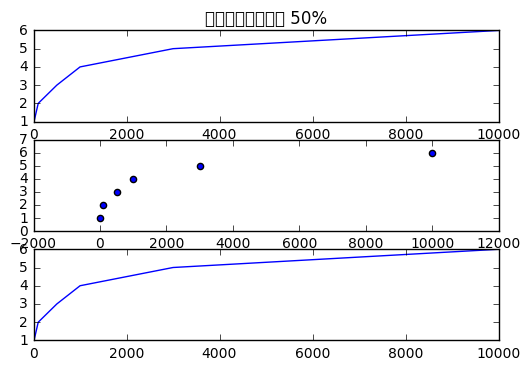

In [79]:
#fig = plt.figure()
#plt.subplot()
#plt.title('Загрузка 50%')   # заголовок
#plt.xlabel('Число работ')   # подпись оси OX
#plt.ylabel('Время')   # подпись оси OY
#plt.legend()   # легенда
#x = [10, 100, 500, 1000, 3000, 10000]
#y = [1, 2, 3, 4, 5, 6]
#plt.plot(x, y, 'r')
#plt.subplot()
#plt.title('Загрузка 60%')   # заголовок
#plt.xlabel('Число работ')   # подпись оси OX
#plt.ylabel('Время')   # подпись оси OY
#plt.legend()   # легенда
font = {'family': 'Droid Sans',
        'weight': 'normal',
        'size': 14}

x = [10, 100, 500, 1000, 3000, 10000]
y = [1, 2, 3, 4, 5, 6]
#plt.plot(x, y, 'r')
fig, axes = plt.subplots(3, 1)
axes[0].set_title(u'Загрузка 50%')   # заголовок    
axes[0].plot(x, y)
axes[1].scatter(x, y)
axes[2].plot(x,y)
